In [120]:
import os
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import xgboost
from sklearn.externals import joblib
from sklearn.utils import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler, LabelEncoder
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras import Sequential
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout, Dense
from keras.models import load_model

Load cleaned data from pickle file

In [2]:
cleaned_df = joblib.load('data/cleaned_df.pkl')

Load top 50 features and extract top 50 features into a list

In [247]:
top_50_feats = pd.read_csv('top50rfinit.csv')
top_50_feats_list = top_50_feats['variable'].tolist()[:40]
top_50_feats_list.append('device_category')

In [248]:
filtered_df = cleaned_df.filter(items=top_50_feats_list, axis='columns')

In [ ]:
filtered_df.head()

Encode x and y into numpy vectors for neural network

In [ ]:
x = filtered_df.drop('device_category', axis=1)
y = filtered_df['device_category']

encoded_x = np.array(x)
label_bin = LabelBinarizer()
label_bin.fit(np.array(y))
encoded_y = label_bin.transform(y)
encoded_y = np.array(encoded_y)

weights = compute_class_weight('balanced', np.unique(y), y)

Neural Network Model Functions

In [ ]:
def build_nn_model(x, y):
    model = Sequential()

    model.add(Dense(100, activation='relu', input_shape=tuple(x.shape[1:])))
    model.add(Dropout(0.20))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dropout(0.25))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dropout(0.25))
    model.add(Dense(y.shape[1], activation='softmax'))


    # op = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    op = optimizers.Adam(lr=0.005)

    model.compile(optimizer=op, metrics=['categorical_accuracy'], loss='categorical_crossentropy')
    return model


def train_nn_model(x, y, model, model_name, weights):

    save_checkpoint = ModelCheckpoint(model_name, save_best_only=True, verbose=1)
    early_stop = EarlyStopping(min_delta=0.01, patience=200, verbose=1, mode='min')
    try:
        model.fit(x, y, batch_size=4000, epochs=100, verbose=2, class_weight=weights,
                  callbacks=[save_checkpoint, early_stop], validation_split=0.2, shuffle=True)
    except Exception as e:
        print(e)

In [ ]:
nn_model = build_nn_model(encoded_x, encoded_y)

In [ ]:
train_nn_model(encoded_x, encoded_y, nn_model, model_name='top50_nn_model.h5', weights=weights)

### Clustering Analysis

Clone smoke detector instances to thrice of its original count (504)

In [249]:
smoke = filtered_df[filtered_df['device_category'] == 'smoke_detector']
smoke_500 = pd.concat([smoke, smoke, smoke], ignore_index=True, axis=0)
smoke_500 = smoke_500.iloc[:,:-1]

In [16]:
smoke_500.shape

(504, 20)

Perform stratified sampling on other classes to trim all class instances, 504 instances per class

In [250]:
no_smoke = filtered_df[filtered_df['device_category'] != 'smoke_detector']
no_smoke_strat, _, _, _ = train_test_split(no_smoke.iloc[:,:-1], no_smoke.iloc[:,-1], random_state=1, train_size=smoke_500.shape[0]*9, test_size=9, stratify=no_smoke.iloc[:,-1])

In [22]:
no_smoke_strat.shape

(4536, 20)

Merge both dataframes back together into one dataframe

In [24]:
clustering_df = pd.concat([smoke_500, no_smoke_strat], ignore_index=True, axis=0)

Perform stratified sample, 100 instances per class for clustering analysis

In [113]:
stratified_x, _, stratified_y, _ = train_test_split(filtered_df.iloc[:,:-1], filtered_df.iloc[:,-1], random_state=1, train_size=50*10, test_size=10, stratify=filtered_df.iloc[:,-1])
stratified_x = stratified_x.reset_index()
le = LabelEncoder()
stratified_y = pd.DataFrame(le.fit_transform(stratified_y), columns=['device_category'])
stratified_df = pd.concat([stratified_x, stratified_y], axis=1, ignore_index=True)

In [105]:
stratified_x.head()

,ttl_min,packet_inter_arrivel_median,ttl_B_min,packet_inter_arrivel_A_avg,packet_inter_arrivel_A_sum,B_port_is_8080,packet_inter_arrivel_min,ttl_thirdQ,packet_inter_arrivel_A_median,ttl_B_firstQ,packet_inter_arrivel_A_min,ttl_avg,packet_inter_arrivel_A_max,packet_inter_arrivel_stdev,packet_inter_arrivel_avg,packet_inter_arrivel_A_firstQ,packet_inter_arrivel_sum,packet_inter_arrivel_firstQ,packet_inter_arrivel_max,ttl_B_thirdQ
379922,255,0.499949,0,178.318669,4101.329376,1,4.741480e-01,255.0,0.499949,0.0,4.741480e-01,255.000000,1998.516315,464.725852,178.318669,0.499319,4101.329376,0.499319,1998.516315,0.0
17371,48,0.000251,48,0.014146,66.910457,0,0.000000e+00,64.0,0.001048,49.0,0.000000e+00,53.896806,30.437901,0.258118,0.004704,0.000011,67.004942,0.000121,30.385188,49.0
279742,255,0.499927,0,0.499890,1.499670,1,4.988308e-01,255.0,0.499927,0.0,4.988308e-01,255.000000,0.500912,0.001041,0.499890,0.499379,1.499670,0.499379,0.500912,0.0
141976,34,0.001239,34,0.115635,2.890863,0,9.536743e-07,226.0,0.005184,226.0,9.536743e-07,134.187500,0.842597,0.143074,0.061508,0.000110,2.890863,0.000111,0.842597,226.0
273321,255,0.499730,0,56.856905,397.998332,1,3.990381e-01,255.0,0.499730,0.0,3.990381e-01,255.000000,395.100235,149.151294,56.856905,0.493073,397.998332,0.493073,395.100235,0.0


In [114]:
stratified_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,379922,255,0.499949,0,178.318669,4101.329376,1,4.741480e-01,255.0,0.499949,...,255.000000,1998.516315,464.725852,178.318669,0.499319,4101.329376,0.499319,1998.516315,0.0,5
1,17371,48,0.000251,48,0.014146,66.910457,0,0.000000e+00,64.0,0.001048,...,53.896806,30.437901,0.258118,0.004704,0.000011,67.004942,0.000121,30.385188,49.0,0
2,279742,255,0.499927,0,0.499890,1.499670,1,4.988308e-01,255.0,0.499927,...,255.000000,0.500912,0.001041,0.499890,0.499379,1.499670,0.499379,0.500912,0.0,2
3,141976,34,0.001239,34,0.115635,2.890863,0,9.536743e-07,226.0,0.005184,...,134.187500,0.842597,0.143074,0.061508,0.000110,2.890863,0.000111,0.842597,226.0,1
4,273321,255,0.499730,0,56.856905,397.998332,1,3.990381e-01,255.0,0.499730,...,255.000000,395.100235,149.151294,56.856905,0.493073,397.998332,0.493073,395.100235,0.0,2


Reduced data dimensionality to 2D with Principle Component Analysis (PCA)

In [115]:
pca = PCA(n_components=2, svd_solver='auto', random_state=1)
reduced_array = pca.fit_transform(stratified_df)

Build and fit data to KMeans clustering algorithm, with 10 clusters

In [116]:
kmeans = KMeans(n_clusters=10, random_state=1).fit(reduced_array)

Standard scaling for PCA reduced data to see relative comparison and ease plotting

In [117]:
scaler = StandardScaler()
reduced_array = scaler.fit_transform(reduced_array)

In [118]:
pd.DataFrame(reduced_array).head()

,0,1
0,-1.536399,-0.176689
1,1.567414,-0.132937
2,-0.677967,-0.445522
3,0.501050,-0.284462
4,-0.623145,-0.392209


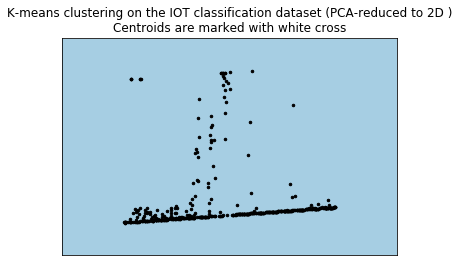

In [131]:
h = 0.05

# Obtain decision boundaries of plot
x_min, x_max = reduced_array[:, 0].min() - 1, reduced_array[:, 0].max() + 1
y_min, y_max = reduced_array[:, 1].min() - 1, reduced_array[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each example. Use the last trained model
cluster_plot = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Produce the colours
cluster_plot = cluster_plot.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(cluster_plot, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_array[:, 0], reduced_array[:, 1], 'k.', markersize=5)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='D', linewidths=3, c='w', s=500**2)

plt.title('K-means clustering on the IOT classification dataset (PCA-reduced to 2D )\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [179]:
knn = KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='auto', p=2, n_jobs=-1, leaf_size=15)

In [251]:
test_x, test_y = smoke.iloc[:,:-1], smoke.iloc[:,-1]
train_x, train_y = no_smoke.iloc[:,:-1], no_smoke.iloc[:,-1]

In [252]:
train_x, train_y, val_x, val_y = train_x.iloc[:-200,:], train_y.iloc[:-200], train_x.iloc[-200:,:], train_y.iloc[-200:]

In [253]:
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')

In [296]:
val_distance = knn.kneighbors(val_x, n_neighbors=9, return_distance=True)
val_distance_df = pd.DataFrame([[distance for distance in row]for row in val_distance[0]])
val_mean_distance = val_distance_df.mean(axis=1)
val_sd = val_distance_df.std(axis=1, numeric_only=True)
val_min = val_distance_df.min(axis=1, numeric_only=True)
val_total_distance = val_distance_df.sum(axis=1)
val_skew = val_distance_df.skew(axis=1)
val_sem = val_distance_df.sem(axis=1, numeric_only=1)
avg_skew = np.average(val_skew)


# val_distance_df['mean_distance'] = val_mean_distance
val_distance_df['sem'] = val_sem
val_distance_df['sd'] = val_sd
# val_distance_df['-sd_from_mean'] = val_mean_distance - (1*val_sd)
# val_distance_df['min_distance'] = val_min
# val_distance_df['total_dist'] = val_total_distance
val_distance_df['skew'] = val_skew
val_distance_df['shortest_dist_se'] = val_min / val_sd
# val_distance_df['considered_as_known'] = np.where((((val_distance_df['min_distance']/val_distance_df['total_dist']) <= 0.1) & 
#                                                   (val_distance_df['min_distance'] < val_distance_df['-sd_from_mean']))
#                                                   , True, False)
# val_distance_df['considered_as_known'] = np.where((val_distance_df['min_distance'] < val_distance_df['-sd_from_mean']), True, False)

In [297]:
avg_skew

-0.39168457593819633

In [298]:
val_distance_df

,0,1,2,3,4,5,6,7,8,sem,sd,skew,shortest_dist_se
0,0.274214,23.426240,23.937712,23.938385,33.562594,46.340753,46.343368,48.387386,63.852634,6.294735,18.884204,-0.288836,0.014521
1,0.025685,16.677775,17.145504,32.821000,32.821023,32.821059,32.821141,32.821146,36.137558,4.040379,12.121136,-1.483240,0.002119
2,56.194797,60.450886,60.479773,85.062113,85.062289,85.475874,88.805672,96.112947,106.055692,5.804305,17.412914,-0.256073,3.227191
3,1.193562,35.556716,45.120726,57.968714,69.383935,90.147394,90.240480,92.901194,94.897724,10.760935,32.282804,-0.916629,0.036972
4,0.789423,16.165657,16.165666,16.165689,16.165748,16.165856,16.655520,19.500542,33.800985,2.775593,8.326778,0.211225,0.094805
5,0.051168,0.850222,22.402270,22.402270,22.914508,40.649944,43.962058,46.342659,47.505777,6.164219,18.492658,-0.461375,0.002767
6,49.471062,65.948455,99.538710,103.781352,113.671981,115.116961,128.207387,138.604864,153.814739,11.060770,33.182311,-0.574601,1.490887
7,0.840176,16.165648,16.165668,16.165695,16.165823,16.165835,16.655438,19.500372,33.800881,2.771507,8.314522,0.220469,0.101049
8,1.199114,35.559993,45.122859,57.969445,69.384885,90.147381,90.240500,92.902574,94.898225,10.760382,32.281146,-0.916575,0.037146
9,0.293675,23.426578,23.937827,23.938474,33.561157,46.340849,46.343451,48.387393,63.848812,6.293014,18.879042,-0.288014,0.015556


In [290]:
val_distance_df.groupby('considered_as_known').size()

considered_as_known
False     50684
True     348296
dtype: int64

In [284]:
test_distance = knn.kneighbors(test_x, n_neighbors=9, return_distance=True)
test_distance_df = pd.DataFrame([[distance for distance in row]for row in test_distance[0]])
test_mean_distance = test_distance_df.mean(axis=1)
test_sd = test_distance_df.std(axis=1, numeric_only=True)
test_min = test_distance_df.min(axis=1, numeric_only=True)
test_total_distance = test_distance_df.sum(axis=1)
test_skew = test_distance_df.skew(axis=1)

test_distance_df['mean_distance'] = test_mean_distance
test_distance_df['sd'] = test_sd
test_distance_df['-sd_from_mean'] = test_mean_distance - (1*test_sd)
test_distance_df['min_distance'] = test_min
test_distance_df['total_dist'] = test_total_distance
test_distance_df['skew'] = test_skew
test_distance_df['considered_as_unknown'] = np.where(((test_distance_df['min_distance']/test_distance_df['total_dist']) > 0.1) |
                                                     (test_distance_df['min_distance'] > test_distance_df['-sd_from_mean'])
                                                     , True, False)
# test_distance_df['considered_as_unknown'] = np.where((test_distance_df['min_distance'] < test_distance_df['-sd_from_mean']), False, True)

In [285]:
test_distance_df

,0,1,2,3,4,5,6,7,8,mean_distance,sd,-sd_from_mean,min_distance,total_dist,skew,considered_as_unknown
0,59.682749,59.769647,60.712348,60.712353,60.712370,60.815180,60.852746,60.871799,61.218023,60.594135,0.516528,60.077607,59.682749,545.347214,-1.189745,True
1,37.179811,46.699531,46.752187,51.582697,52.108266,52.700816,56.101145,56.707098,57.177578,50.778792,6.406158,44.372634,37.179811,457.009128,-1.232997,False
2,34.934890,44.672315,44.905500,49.782782,50.321179,50.690719,54.405394,55.020245,55.609565,48.926954,6.592020,42.334934,34.934890,440.342588,-1.225033,False
3,36.451843,46.042785,46.045238,50.913801,51.443610,51.956098,55.458532,56.068353,56.583311,50.107064,6.436759,43.670305,36.451843,450.963572,-1.226001,False
4,36.658256,46.990362,47.800099,52.744322,53.296531,53.556729,57.473925,58.082301,58.705588,51.700902,7.016776,44.684126,36.658256,465.308114,-1.284051,False
5,36.433185,46.031341,46.034096,50.905612,51.435496,51.947686,55.451632,56.061898,56.576513,50.097495,6.440529,43.656967,36.433185,450.877459,-1.226452,False
6,32.209429,42.134313,42.756783,47.719148,48.272589,48.594697,52.466354,53.068256,53.681082,46.766961,6.855412,39.911549,32.209429,420.902651,-1.233472,False
7,33.413458,43.273516,43.779500,48.762180,49.308953,49.773273,53.460419,54.054781,54.595850,47.824659,6.782914,41.041745,33.413458,430.421929,-1.241480,False
8,35.698142,45.341506,45.421121,50.284820,50.818196,51.245642,54.862272,55.477053,56.037659,49.465157,6.490682,42.974475,35.698142,445.186412,-1.221578,False
9,36.311821,46.043237,46.255336,51.212935,51.746995,52.370248,55.800248,56.392141,56.844692,50.330850,6.591216,43.739635,36.311821,452.977652,-1.249924,False


In [281]:
test_distance_df.groupby('considered_as_unknown').size()

considered_as_unknown
False    140
True      28
dtype: int64